In [29]:
import os
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import pickle
from scipy.stats import uniform
import copy
from datetime import datetime, timedelta

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

import warnings

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *


# Preparación de los datos

In [30]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Ruido_diario_acumulado.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [31]:
# Se obtienen los datos
df_acoustics = pd.read_csv('data/raw/Ruido_diario_acumulado.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


389519

In [32]:
# Se borran los datos no necesarios
df_acoustics = df_acoustics.drop(columns=['LAEQ', 'LAS01', 'LAS10', 'LAS90', 'LAS99'])

df_acoustics.head()


,NMT,anio,mes,dia,tipo,LAS50
0,3,2014,1,1,D,"54,3"
1,3,2014,1,1,E,56
2,3,2014,1,1,N,"60,9"
3,3,2014,1,1,T,"56,5"
4,4,2014,1,1,D,"63,2"


In [33]:
# Se mantiene solo el tipo "T", que representa el total del día
df_acoustics = df_acoustics.drop(df_acoustics[df_acoustics['tipo'] != 'T'].index)

df_acoustics = df_acoustics.drop(columns='tipo')

df_acoustics.head()


,NMT,anio,mes,dia,LAS50
3,3,2014,1,1,"56,5"
7,4,2014,1,1,"63,9"
11,5,2014,1,1,"58,6"
15,8,2014,1,1,"65,2"
19,10,2014,1,1,"58,7"


In [34]:
for date in df_acoustics.columns[1:-1]:
    df_acoustics[date] = list(map(str, df_acoustics[date]))

df_acoustics['date'] = df_acoustics['anio'] + '-' + df_acoustics['mes'] + '-' + df_acoustics['dia']

df_acoustics = df_acoustics.drop(columns=['anio', 'mes', 'dia'])

df_acoustics.head()


,NMT,LAS50,date
3,3,"56,5",2014-1-1
7,4,"63,9",2014-1-1
11,5,"58,6",2014-1-1
15,8,"65,2",2014-1-1
19,10,"58,7",2014-1-1


In [35]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['date'] = pd.to_datetime(df_acoustics['date'])

df_acoustics = df_acoustics.set_index('date')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20'],
              dtype='datetime64[ns]', name='date', length=97522, freq=None)

In [36]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics['LAS50'] = df_acoustics['LAS50'].astype(str)

for col in df_acoustics.columns[1:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = pd.to_numeric(df_acoustics[col], errors='coerce')
    df_acoustics[col] = df_acoustics[col].astype(float)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97522 entries, 2014-01-01 to 2023-03-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NMT     97522 non-null  int64  
 1   LAS50   97522 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [37]:
# Se pivota la tabla para que cada columna sea una zona
df_acoustics = df_acoustics.pivot_table(index='date', columns='NMT', values='LAS50')

df_acoustics.head()


NMT,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,56.5,63.9,58.6,NaN,65.2,58.7,65.4,60.3,...,60.0,49.0,51.9,52.6,47.8,60.3,NaN,56.2,48.1,50.5
2014-01-02,NaN,NaN,58.0,64.8,60.0,NaN,67.5,61.7,69.1,62.7,...,62.8,51.2,59.7,58.9,51.0,62.7,NaN,60.9,51.6,54.3
2014-01-03,NaN,NaN,58.6,64.7,60.0,NaN,67.2,61.9,69.1,62.4,...,63.5,52.6,58.5,58.9,50.5,62.7,NaN,60.6,50.9,54.0
2014-01-04,NaN,NaN,59.0,64.2,59.3,NaN,67.1,60.3,67.4,61.7,...,61.9,50.4,55.8,60.0,51.1,62.0,NaN,60.1,50.9,52.8
2014-01-05,NaN,NaN,58.0,63.4,57.8,NaN,64.9,58.9,66.1,60.5,...,59.8,48.7,52.7,56.9,47.1,60.1,NaN,58.3,47.9,50.5


In [38]:
# Se establece la frecuencia "D" (diaria)
df_acoustics = df_acoustics.asfreq('D')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       2820 non-null   float64
 1   2       2902 non-null   float64
 2   3       3243 non-null   float64
 3   4       2456 non-null   float64
 4   5       3279 non-null   float64
 5   6       2884 non-null   float64
 6   8       3218 non-null   float64
 7   10      3254 non-null   float64
 8   11      3206 non-null   float64
 9   12      3276 non-null   float64
 10  13      3274 non-null   float64
 11  14      3209 non-null   float64
 12  16      3190 non-null   float64
 13  17      3261 non-null   float64
 14  18      3257 non-null   float64
 15  19      3168 non-null   float64
 16  20      3234 non-null   float64
 17  24      3246 non-null   float64
 18  25      2869 non-null   float64
 19  26      2869 non-null   float64
 20  27      3216 non-null   float64
 21  28      327

In [39]:
# El resto, con una interpolación. Sigue habiendo nulos
df_acoustics = df_acoustics.interpolate(method='spline', order=3)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3001 non-null   float64
 1   2       3000 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3000 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3001 non-null   float64
 19  26      3001 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

In [40]:
# Se imputan los restantes con los vecinos cercanos
imputer = KNNImputer(n_neighbors=5)

imputer.fit(df_acoustics)

df_acoustics = pd.DataFrame(imputer.transform(df_acoustics), columns=df_acoustics.columns, index=df_acoustics.index)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3366 non-null   float64
 1   2       3366 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3366 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3366 non-null   float64
 19  26      3366 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

# ML

## Preparación

In [41]:
# Se crea un dataframe donde el índice es cada zona
new_df = pd.DataFrame(index=df_acoustics.columns, columns=df_acoustics.index)

for col in df_acoustics.columns:
    for row in df_acoustics.index:
        new_df.loc[col, row] = df_acoustics.loc[row, col]

new_df.head()


date,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2023-03-11,2023-03-12,2023-03-13,2023-03-14,2023-03-15,2023-03-16,2023-03-17,2023-03-18,2023-03-19,2023-03-20
NMT,,,,,,,,,,,,,,,,,,,,,
1,64.6,66.62,66.82,65.66,64.26,64.44,65.838602,65.64,65.96,66.06,...,61.6,60.3,61.0,61.3,61.9,62.0,62.0,60.6,59.0,58.5
2,66.78,69.28,69.12,68.54,67.22,66.84,68.233943,68.34,68.16,68.38,...,63.8,62.3,64.0,63.8,64.0,64.0,64.3,63.1,61.7,61.9
3,56.5,58.0,58.6,59.0,58.0,55.7,57.3,56.6,56.7,57.3,...,61.3,59.0,58.6,58.6,58.7,58.6,58.4,58.3,57.5,55.8
4,63.9,64.8,64.7,64.2,63.4,63.1,64.1,64.2,64.4,64.8,...,60.1,59.0,59.0,58.3,58.8,59.0,59.3,58.9,58.7,57.5
5,58.6,60.0,60.0,59.3,57.8,57.1,59.2,59.1,59.1,59.8,...,57.160822,57.130517,57.098419,57.064454,57.028545,56.990617,59.4,56.8,56.0,56.1


In [42]:
# Se pasan los valores a "float"
new_df = new_df.astype(float)

new_df.head()


date,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2023-03-11,2023-03-12,2023-03-13,2023-03-14,2023-03-15,2023-03-16,2023-03-17,2023-03-18,2023-03-19,2023-03-20
NMT,,,,,,,,,,,,,,,,,,,,,
1,64.60,66.62,66.82,65.66,64.26,64.44,65.838602,65.64,65.96,66.06,...,61.600000,60.300000,61.000000,61.300000,61.900000,62.000000,62.0,60.6,59.0,58.5
2,66.78,69.28,69.12,68.54,67.22,66.84,68.233943,68.34,68.16,68.38,...,63.800000,62.300000,64.000000,63.800000,64.000000,64.000000,64.3,63.1,61.7,61.9
3,56.50,58.00,58.60,59.00,58.00,55.70,57.300000,56.60,56.70,57.30,...,61.300000,59.000000,58.600000,58.600000,58.700000,58.600000,58.4,58.3,57.5,55.8
4,63.90,64.80,64.70,64.20,63.40,63.10,64.100000,64.20,64.40,64.80,...,60.100000,59.000000,59.000000,58.300000,58.800000,59.000000,59.3,58.9,58.7,57.5
5,58.60,60.00,60.00,59.30,57.80,57.10,59.200000,59.10,59.10,59.80,...,57.160822,57.130517,57.098419,57.064454,57.028545,56.990617,59.4,56.8,56.0,56.1


## Baseline

### Target: 2023

In [43]:
# Se establecen los modelos que se quieren probar
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'XGBRegressor': ''}

In [44]:
# Se eligen las fechas del 2023 para test
cols_2023 = new_df.columns[-79:]


In [45]:
# Se lanza el "baseline"
baseline = Regression(new_df, cols_2023)
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.65 sec(s). Total time: 0.65
Starting Ridge:
- Ridge done in 0.57 sec(s). Total time: 1.22
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.55 sec(s). Total time: 1.77
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.92 sec(s). Total time: 2.69
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 30.62 sec(s). Total time: 33.31
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 103.27 sec(s). Total time: 136.58


,LinearRegression,Ridge,KNeighborsRegressor,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,1.269383,1.270201,2.580193,2.633070,2.212864,2.322556,LinearRegression,DecisionTreeRegressor: random_state=43
mse,1.865577,1.867026,7.406862,7.568406,5.354806,5.880467,LinearRegression,DecisionTreeRegressor: random_state=43
mae,1.069101,1.069546,2.114834,2.316040,1.786065,1.982570,LinearRegression,DecisionTreeRegressor: random_state=43
r2_score,0.900839,0.900809,0.633405,0.593539,0.710393,0.598727,LinearRegression,XGBRegressor: random_state=43
mape,0.018969,0.018976,0.038110,0.041323,0.032000,0.034746,LinearRegression,DecisionTreeRegressor: random_state=43


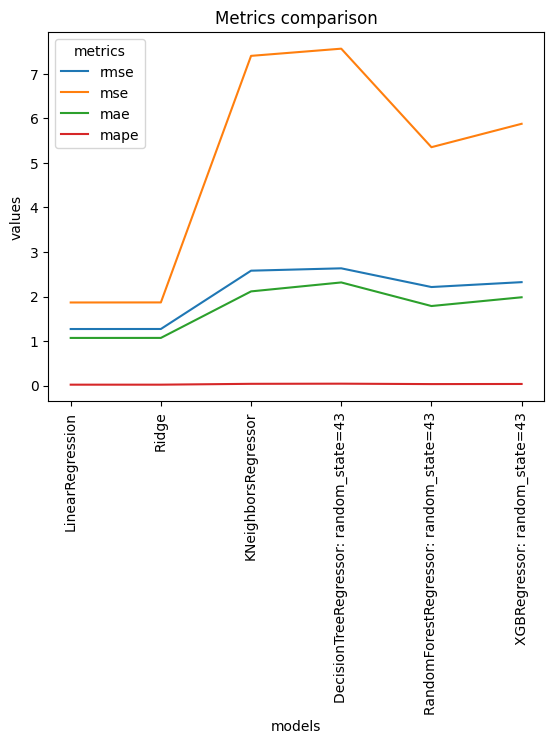

In [46]:
# Se visualizan los resultados. Ridge es el mejor, ya que la relación es lineal y las variables están bastante correlacionadas
baseline.visualize('rmse', 'mse', 'mae', 'mape')


### Target: una sola fecha

In [47]:
Regression.add_models('SVR')

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'XGBRegressor': '',
 'SVR': ''}

In [48]:
# Se lanza el "baseline"
baseline = Regression(new_df, '2023-03-20')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43'],
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.52 sec(s). Total time: 0.52
Starting Ridge:
- Ridge done in 0.7 sec(s). Total time: 1.22
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.57 sec(s). Total time: 1.8
Starting SVR:
- SVR done in 0.54 sec(s). Total time: 2.34
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.57 sec(s). Total time: 2.91
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 17.75 sec(s). Total time: 20.66
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 13.57 sec(s). Total time: 34.23


,LinearRegression,Ridge,KNeighborsRegressor,SVR,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,0.797858,0.799789,2.702677,4.288405,2.578100,2.168538,2.387618,LinearRegression,SVR
mse,0.661254,0.661939,7.539400,19.088063,7.075900,4.851653,6.349748,LinearRegression,SVR
mae,0.657825,0.656647,2.415600,3.517257,2.095000,1.821000,1.975811,Ridge,SVR
r2_score,0.946010,0.946648,0.540390,-0.327153,0.488314,0.677752,0.572995,Ridge,XGBRegressor: random_state=43
mape,0.012070,0.012061,0.043946,0.065401,0.038423,0.033043,0.035100,Ridge,SVR


#### Selección de hiperparámetros

## Modelaje

### Prueba


In [191]:
# Se hace la predicción de las fechas de 2023
df_to_train = new_df.copy()

df_to_train = df_to_train.drop(columns=new_df.columns[-79:])

df_to_train = df_to_train.drop(columns=df_to_train.columns[:3251])

df_to_train.head()


date,2022-11-26,2022-11-27,2022-11-28,2022-11-29,2022-11-30,2022-12-01,2022-12-02,2022-12-03,2022-12-04,2022-12-05,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
NMT,,,,,,,,,,,,,,,,,,,,,
1,61.2,59.7,61.7,61.2,61.1,61.2,61.5,61.0,59.4,63.0,...,62.0,62.2,58.5,57.0,58.9,61.2,61.1,61.4,61.4,59.7
2,64.3,62.6,65.4,64.5,64.5,64.3,64.7,64.0,63.6,68.5,...,64.9,65.0,62.0,60.9,62.9,64.3,64.2,64.2,64.3,63.9
3,60.0,57.6,59.1,59.7,57.9,58.2,58.3,58.5,57.2,57.5,...,58.0,56.6,54.4,52.7,56.9,58.8,58.7,58.7,58.4,56.4
4,61.5,60.4,59.9,60.1,59.8,60.4,61.0,61.1,61.0,61.0,...,61.2,61.4,58.6,58.2,60.6,60.5,60.7,60.5,60.8,59.0
5,58.8,56.2,58.7,58.8,59.1,59.0,58.0,56.7,55.9,59.8,...,58.2,58.6,56.0,55.0,56.5,58.0,58.0,57.7,58.0,55.9


In [192]:
# Se hace la predicción de las fechas de 2023
for _ in range(5):
    last_column = str(df_to_train.columns[-1]).split()[0]
    X = df_to_train.drop(columns=last_column)
    y = df_to_train[last_column]
    
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)

    first_column = str(df_to_train.columns[0]).split()[0]
    df_to_train = df_to_train.drop(columns=first_column)
    pred = model.predict(df_to_train.values)

    new_date = datetime.strptime(last_column, '%Y-%m-%d')
    new_date = new_date + timedelta(days=1)

    df_to_train[str(new_date).split()[0]] = pred

df_to_train.head()


date,2022-12-01,2022-12-02,2022-12-03,2022-12-04,2022-12-05,2022-12-06,2022-12-07,2022-12-08,2022-12-09,2022-12-10,...,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05
NMT,,,,,,,,,,,,,,,,,,,,,
1,61.2,61.5,61.0,59.4,63.0,60.0,61.4,61.8,63.1,61.5,...,61.2,61.1,61.4,61.4,59.7,55.826503,59.032474,47.993521,61.438633,57.186896
2,64.3,64.7,64.0,63.6,68.5,63.9,64.7,67.0,67.2,64.9,...,64.3,64.2,64.2,64.3,63.9,55.530793,61.110258,49.571671,66.693336,61.990466
3,58.2,58.3,58.5,57.2,57.5,56.7,57.8,57.0,57.6,58.6,...,58.8,58.7,58.7,58.4,56.4,49.501379,58.190410,51.112076,59.662764,56.311158
4,60.4,61.0,61.1,61.0,61.0,60.5,60.6,61.1,61.4,61.7,...,60.5,60.7,60.5,60.8,59.0,58.980374,61.816939,55.275343,59.528046,59.414333
5,59.0,58.0,56.7,55.9,59.8,56.5,57.9,58.4,59.6,57.3,...,58.0,58.0,57.7,58.0,55.9,49.017227,53.159898,42.271138,57.100652,48.227569


In [193]:
# La predicción de 2023 es buena
pred_total = df_to_train[cols_2023]
test_total = new_df[cols_2023]

print(f'rmse: {mean_squared_error(test_total, pred_total, squared=False)}')
print(f'mse: {mean_squared_error(test_total, pred_total)}')
print(f'mae: {mean_absolute_error(test_total, pred_total)}')
print(f'r2: {r2_score(test_total, pred_total)}')
print(f'mape: {mean_absolute_percentage_error(test_total, pred_total)}')


KeyError: "[Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-07 00:00:00'), Timestamp('2023-01-08 00:00:00'), Timestamp('2023-01-09 00:00:00'), Timestamp('2023-01-10 00:00:00'), Timestamp('2023-01-11 00:00:00'), Timestamp('2023-01-12 00:00:00'), Timestamp('2023-01-13 00:00:00'), Timestamp('2023-01-14 00:00:00'), Timestamp('2023-01-15 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-01-17 00:00:00'), Timestamp('2023-01-18 00:00:00'), Timestamp('2023-01-19 00:00:00'), Timestamp('2023-01-20 00:00:00'), Timestamp('2023-01-21 00:00:00'), Timestamp('2023-01-22 00:00:00'), Timestamp('2023-01-23 00:00:00'), Timestamp('2023-01-24 00:00:00'), Timestamp('2023-01-25 00:00:00'), Timestamp('2023-01-26 00:00:00'), Timestamp('2023-01-27 00:00:00'), Timestamp('2023-01-28 00:00:00'), Timestamp('2023-01-29 00:00:00'), Timestamp('2023-01-30 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-01 00:00:00'), Timestamp('2023-02-02 00:00:00'), Timestamp('2023-02-03 00:00:00'), Timestamp('2023-02-04 00:00:00'), Timestamp('2023-02-05 00:00:00'), Timestamp('2023-02-06 00:00:00'), Timestamp('2023-02-07 00:00:00'), Timestamp('2023-02-08 00:00:00'), Timestamp('2023-02-09 00:00:00'), Timestamp('2023-02-10 00:00:00'), Timestamp('2023-02-11 00:00:00'), Timestamp('2023-02-12 00:00:00'), Timestamp('2023-02-13 00:00:00'), Timestamp('2023-02-14 00:00:00'), Timestamp('2023-02-15 00:00:00'), Timestamp('2023-02-16 00:00:00'), Timestamp('2023-02-17 00:00:00'), Timestamp('2023-02-18 00:00:00'), Timestamp('2023-02-19 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2023-02-21 00:00:00'), Timestamp('2023-02-22 00:00:00'), Timestamp('2023-02-23 00:00:00'), Timestamp('2023-02-24 00:00:00'), Timestamp('2023-02-25 00:00:00'), Timestamp('2023-02-26 00:00:00'), Timestamp('2023-02-27 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-01 00:00:00'), Timestamp('2023-03-02 00:00:00'), Timestamp('2023-03-03 00:00:00'), Timestamp('2023-03-04 00:00:00'), Timestamp('2023-03-05 00:00:00'), Timestamp('2023-03-06 00:00:00'), Timestamp('2023-03-07 00:00:00'), Timestamp('2023-03-08 00:00:00'), Timestamp('2023-03-09 00:00:00'), Timestamp('2023-03-10 00:00:00'), Timestamp('2023-03-11 00:00:00'), Timestamp('2023-03-12 00:00:00'), Timestamp('2023-03-13 00:00:00'), Timestamp('2023-03-14 00:00:00'), Timestamp('2023-03-15 00:00:00'), Timestamp('2023-03-16 00:00:00'), Timestamp('2023-03-17 00:00:00'), Timestamp('2023-03-18 00:00:00'), Timestamp('2023-03-19 00:00:00'), Timestamp('2023-03-20 00:00:00')] not in index"

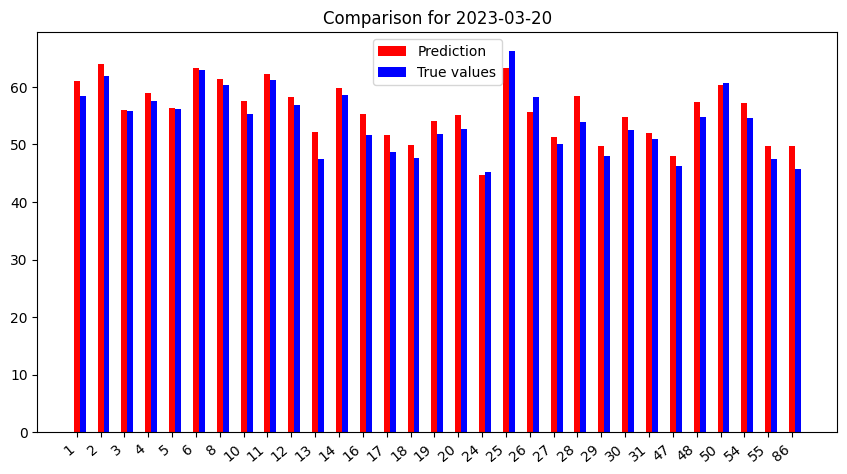

In [140]:
# Se visualiza
plt.rc("figure", figsize=(8,4)) 
X = np.arange(len(pred_total['2023-03-20']))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, list(pred_total['2023-03-20']), color = 'r', width = 0.25)
ax.bar(X + 0.25, list(test_total['2023-03-20']), color = 'b', width = 0.25)
plt.xticks([i for i, val in enumerate(test_total['2023-03-20'].index)], test_total['2023-03-20'].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(labels=['Prediction', 'True values'])
plt.title('Comparison for 2023-03-20')
plt.show()


In [141]:
coef = model.coef_

coef.tolist()


[0.0011849503225573738,
 -2.816321091290993e-05,
 0.0005310915697885562,
 0.00017240559795575315,
 2.4038916313566168e-05,
 0.000563642969206576,
 0.0002918051218761678,
 0.00037333994115324956,
 0.00040176347548061703,
 0.0004009407639887476,
 0.00013269841118588186,
 0.0004749752530126302,
 5.191893893500897e-05,
 0.0005866514086283288,
 0.0003560992799683776,
 0.00046532002944970247,
 -0.0004022132487715846,
 -9.397031822041674e-05,
 0.0006651880365103999,
 0.0005519331723652256,
 0.00025334048679164173,
 -1.90785366307965e-05,
 -0.0004643107715309212,
 0.0003446886326559289,
 0.00011838291758263315,
 0.0007105186794141293,
 0.00016037492585365854,
 0.00012372699016419128,
 -0.0002366726002569644,
 0.0003691631672810158,
 0.0006012637826159661,
 3.306119727140818e-05,
 0.0003655419070930234,
 0.000290495908001784,
 0.0003440708898623629,
 0.00045517972266173693,
 0.000656360140269929,
 -2.8949880805298157e-05,
 0.0004932209589436747,
 0.0001681006769538538,
 7.737696226394604e-05,
 

In [127]:
intercept = model.intercept_

intercept


4.078538113925092

### Entrenamiento

In [ ]:
# Se entrena para obtener la primera fecha de 2024
df_to_train = new_df.copy()

for i in range(287):
    last_column = str(df_to_train.columns[-1]).split()[0]
    X = df_to_train.drop(columns=last_column)
    y = df_to_train[last_column]
    
    model = Ridge(fit_intercept=False,
                    alpha=1.0
                    )
    model.fit(X, y)

    first_column = str(df_to_train.columns[0]).split()[0]
    df_to_train = df_to_train.drop(columns=first_column)
    pred = model.predict(df_to_train.values)

    new_date = datetime.strptime(last_column, '%Y-%m-%d')
    new_date = new_date + timedelta(days=1)

    df_to_train[str(new_date).split()[0]] = pred

df_to_train.head()


date,2014-10-15,2014-10-16,2014-10-17,2014-10-18,2014-10-19,2014-10-20,2014-10-21,2014-10-22,2014-10-23,2014-10-24,...,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31,2024-01-01
NMT,,,,,,,,,,,,,,,,,,,,,
1,66.08,65.74,66.016684,64.88,63.52,65.099537,65.258255,65.079537,65.185482,65.94,...,59.570088,59.566311,59.562550,59.558854,59.554926,59.550668,59.547167,59.543813,59.539910,59.535907
2,68.38,67.94,68.120000,67.50,66.56,67.557703,67.558780,67.377703,67.637703,68.04,...,62.553039,62.549377,62.545698,62.542020,62.538105,62.534087,62.530335,62.526749,62.522892,62.518889
3,58.40,58.00,58.100000,58.90,57.20,57.700000,57.800000,57.600000,58.700000,58.50,...,54.270407,54.267441,54.264562,54.261595,54.258570,54.255429,54.252290,54.249506,54.246398,54.243317
4,63.80,63.70,64.400000,63.90,62.70,63.200000,63.300000,62.900000,63.200000,63.80,...,57.472462,57.468694,57.465157,57.461560,57.457818,57.453901,57.450039,57.446471,57.442753,57.438976
5,59.00,59.20,59.800000,58.30,57.10,58.900000,58.800000,59.000000,59.100000,59.80,...,54.489569,54.486315,54.483033,54.479694,54.475895,54.471749,54.466720,54.462273,54.458911,54.455519


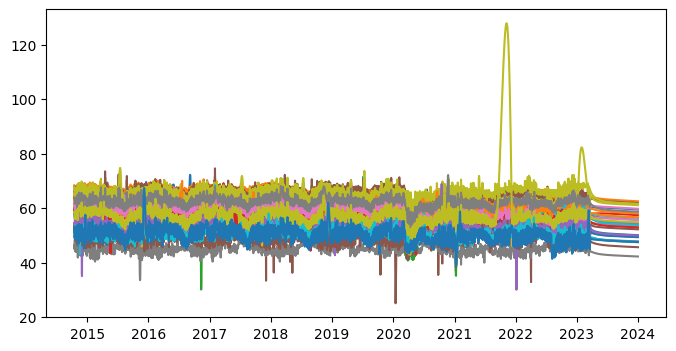

In [ ]:
plt.plot(df_to_train.T)
plt.show()


### OMS